# Preliminary results for label detection and classification

1. Can we find labels on images of herbarium specimens.
1. Can we determine if the label is typewritten, handwritten, or both.

## Ancilllary goals

1. Use a preexisting model. In this case, Faster-RCNN with a ResNet50 backbone. We're not doing anything that requires a new model.
1. Fine-tune an already trained model. The model was trained on the COCO dataset. We're only looking for labels on the images, so any model pre-trained on the COCO dataset should be more than enough for this task.

In [1]:
import sys
sys.path.append('..')

In [2]:
from pathlib import Path
from textwrap import dedent
import pdb

from tqdm import tqdm
from ipywidgets import interact, fixed
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import seaborn as sn

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import pylib.transforms as T
from pylib.engine import train_one_epoch, evaluate
import pylib.utils

from pylib.label_babel_dataset import LabelBabelDataset

The Python environment.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -i -z -v -p torch,torchvision

EST 2020-02-24T10:50:09-05:00

CPython 3.7.5
IPython 7.11.1

torch 1.4.0
torchvision 0.5.0


# Constants

In [4]:
DATA_DIR = Path('..') / 'data'

TRN_DIR = DATA_DIR / 'train'
VAL_DIR = DATA_DIR / 'valid'
MODEL_DIR = DATA_DIR / 'models'

VAL_CSV = DATA_DIR / 'valid.csv'
TRN_CSV = DATA_DIR / 'train.csv'

BOX = 'box'
CAT = 'category'
PATH = 'path'
CLASS = 'class'
SUB_ID = 'subject_id'
PRED_BOX = 'predicted_box'
PRED_CLASS = 'predicted_class'
PRED_CAT = 'predicted_category'
IOU = 'IOU'

DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True

CATS = ['background', 'handwritten', 'typewritten']
CLASSES = len(CATS)

CHECKPOINT = 'checkpoint_{}.pth.tar'

# Load data-frames

Read in the hold-out dataset. The model was *not* trained on this data.

**However the data did come from the same expedition as the training data & it may, therefore, contain a hidden bias.**

I'm also loading the training dataset just to see how that fared.

In [5]:
def load_df(df_path):
    df = pd.read_csv(df_path, index_col='subject_id').reset_index()
    df[PRED_CLASS] = None
    df[PRED_CAT] = None
    df[PRED_BOX] = None
    df[IOU] = None
    return df

In [6]:
val_df = load_df(VAL_CSV)
trn_df = load_df(TRN_CSV)

val_df.head()

subject_id     category  class                   box  \
0     2995202  typewritten      2  [228, 459, 367, 568]   
1     2995203  typewritten      2  [238, 462, 377, 572]   
2     2995205  typewritten      2  [252, 486, 373, 564]   
3     2995213  typewritten      2  [224, 474, 373, 566]   
4     2995216  handwritten      1  [239, 462, 367, 562]   

                     path                 original predicted_class  \
0  data/valid/2995202.jpg  data/images/2995202.jpg            None   
1  data/valid/2995203.jpg  data/images/2995203.jpg            None   
2  data/valid/2995205.jpg  data/images/2995205.jpg            None   
3  data/valid/2995213.jpg  data/images/2995213.jpg            None   
4  data/valid/2995216.jpg  data/images/2995216.jpg            None   

  predicted_category predicted_box  \
0               None          None   
1               None          None   
2               None          None   
3               None          None   
4               None          None   

                                      predicted_text  \
0  FLORA OF ARK:\n\nCORNACEAE Cornus drummondii €...   
1  FLORA OF ARKANSAS.\nCULTIVATED!\nCORNACEAE\n\n...   
2                                                NaN   
3  CORNACEAE\nHERBARIUM OF THE UNIVERSITY OF ARKA...   
4                                                NaN   

     predicted_box_original   IOU  
0   [924, 1854, 1463, 2281]  None  
1   [942, 1858, 1505, 2295]  None  
2  [1020, 1928, 1492, 2272]  None  
3   [899, 1906, 1481, 2261]  None  
4   [943, 1843, 1478, 2251]  None

# Define dataset to handle image & its boxes

# The model

- Faster R-CNN with a ResNet50 backbone.
- The model was previously trained on the COCO dataset.
- The training dataset has 4865 labeled images.
- The validation dataset has 1216 labeled images.
- I trained the model for *only* 5 epochs
- There was almost no data augmentation.

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, CLASSES)

In [8]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
val_dataset = LabelBabelDataset(val_df, get_transform(train=False))
trn_dataset = LabelBabelDataset(trn_df, get_transform(train=False))

In [10]:
model.to(DEVICE)
model.eval();

# Load the fine-tuned model weights

In [11]:
last_checkpoint = sorted(MODEL_DIR.glob(CHECKPOINT.format('*')))[-1]

state = torch.load(last_checkpoint)

model.load_state_dict(state['state_dict'])

state['epoch']

5

# Utility functions for display & evaluation

In [12]:
def intersection_over_area(box1, box2):
    area1 = abs(box1[2] - box1[0]) * abs(box1[3] - box1[1])
    area2 = abs(box2[2] - box2[0]) * abs(box2[3] - box2[1])
    inter = (min(box1[2], box2[2]) - max(box1[0], box2[0])) \
        * (min(box1[3], box2[3]) - max(box1[1], box2[1]))
    inter = max(0, inter)
    return abs(inter / (area1 + area2 - inter))

In [13]:
def draw_rectangle(ax, bbox, color):
    wide = abs(bbox[2] - bbox[0])
    high = abs(bbox[3] - bbox[1])
    rect = patches.Rectangle(
        bbox[:2],
        wide, high,
        fill=False,
        edgecolor=color,
        lw=2)
    patch = ax.add_patch(rect)

In [14]:
def draw_text(ax, position, text, fontsize=12):
    ax.text(
        *position,
        text,
        verticalalignment='top',
        color='black',
        fontsize=fontsize,
        fontfamily='monospace',
        weight='bold',
        bbox=dict(
            boxstyle='round',
            facecolor='white',
            edgecolor='black'))

# Explore results

Key:
- Blue box is the target gotten from the reconciled data.
- Red box is what the model says is the best prediction.
- Yellow boxes (0 or more) are other predictions by the model.

Sideways: 518-541  748-754

Better: 1182,1213

In [17]:
def show_results(dataset, idx, figsize):
    image, target = dataset[idx]

    subject_id = target['image_id'][0].numpy()

    t_class = CATS[target['labels'][0].numpy()]
    t_box = target['boxes'][0].numpy()

    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.axis('off')

    with torch.no_grad():
        prediction = model([image.to(DEVICE)])

    p_class = CATS[prediction[0]['labels'].cpu()[0].numpy()]
    p_box = prediction[0]['boxes'].cpu()[0].numpy()

    iou = round(intersection_over_area(t_box, p_box), 2)
    class_flag = 'Equal' if t_class == p_class else 'NOT EQUAL'
    box_flag = '' if iou >= 0.8 else 'AREA MISMATCH'

    text = dedent(f"""\
            Subject ID:     {subject_id}
            Target:         {t_class} (blue)
            Top Prediction: {p_class} (red)
            Other predictions: (yellow)
            Class result:   {class_flag}
            IOU:            {iou:0.2} {box_flag}""")

    image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

    ax.imshow(image)
    draw_text(ax, (10, 10), text)

    draw_rectangle(ax, t_box, 'blue')

    # Show the boxes in reverse order so the seleted one is uncovered
    boxes = prediction[0]['boxes'].cpu().numpy()
    for i, box in enumerate(boxes[::-1], 1):
        if i != len(boxes):
            continue
        color = 'red' if i == len(boxes) else 'yellow'
        draw_rectangle(ax, box, color)

    plt.show()


interact(
    show_results,
    dataset=fixed(val_dataset),
    idx=(0, val_df.shape[0] - 1),
    figsize=([6, 8, 10, 12, 15, 20, 25]))
# show_results(val_dataset, 0, 12)

interactive(children=(IntSlider(value=607, description='idx', max=1215), Dropdown(description='figsize', optio…

<function __main__.show_results(dataset, idx, figsize)>

# Show N-across results

In [15]:
def show_multiple_results(indices, height, width=None):
    ncols = len(indices)

    if not width:
        width = height * ncols * 0.667

    fig, axes = plt.subplots(
        nrows=1,
        ncols=ncols,
        figsize=(width, height),
        constrained_layout=True)

    for i, idx in enumerate(indices):
        image, target = val_dataset[idx]

        subject_id = target['image_id'][0].numpy()

        t_class = CATS[target['labels'][0].numpy()]
        t_box = target['boxes'][0].numpy()

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])

        p_class = CATS[prediction[0]['labels'].cpu()[0].numpy()]
        p_box = prediction[0]['boxes'].cpu()[0].numpy()

        iou = round(intersection_over_area(t_box, p_box), 2)
        class_flag = 'Equal' if t_class == p_class else 'NOT EQUAL'
        box_flag = '' if iou >= 0.8 else 'AREA MISMATCH'

#         text = dedent(f"""\
#                 Subject ID:     {subject_id}
#                 Target:         {t_class} (blue)
#                 Top Prediction: {p_class} (red)
#                 Other predictions: (yellow)
#                 Class result:   {class_flag}
#                 IoU:            {iou:0.2} {box_flag}""")

        text = dedent(f"""\
                Subject ID:     {subject_id}
                Target:         {t_class} (blue)
                Top Prediction: {p_class} (red)
                Class result:   {class_flag}
                IOU:            {iou:0.2} {box_flag}""")

        image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

        axes[i].imshow(image)
        draw_text(axes[i], (10, 10), text)

        draw_rectangle(axes[i], t_box, 'blue')

        # Show the boxes in reverse order so the seleted one is uncovered
        boxes = prediction[0]['boxes'].cpu().numpy()
        for j, box in enumerate(boxes[::-1], 1):
            color = 'red' if j == len(boxes) else 'yellow'
            draw_rectangle(axes[i], box, color)

    for ax in axes.flat:
        ax.axis('off')

    plt.show()

# Object detection results IOU >= 90%

Intersection over union >= 90%: 1097 (90.21% of the images)

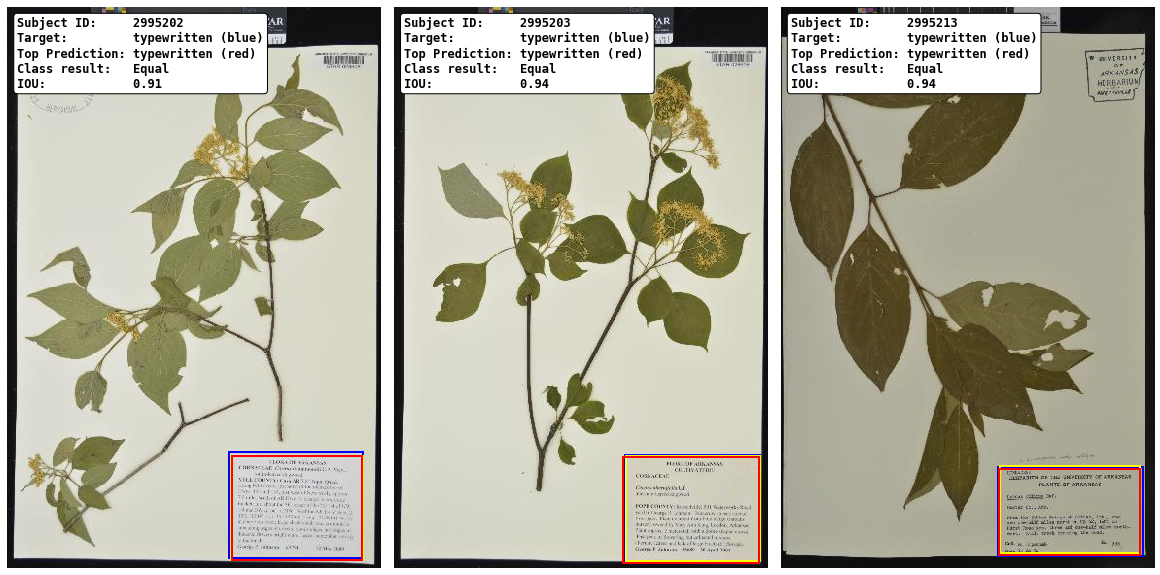

In [16]:
show_multiple_results([0, 1, 3], 8)

# Object detection results IOU >= 90% (image orientation)

I didn't expect this model to handle different orientations without more data augmentation but it did.

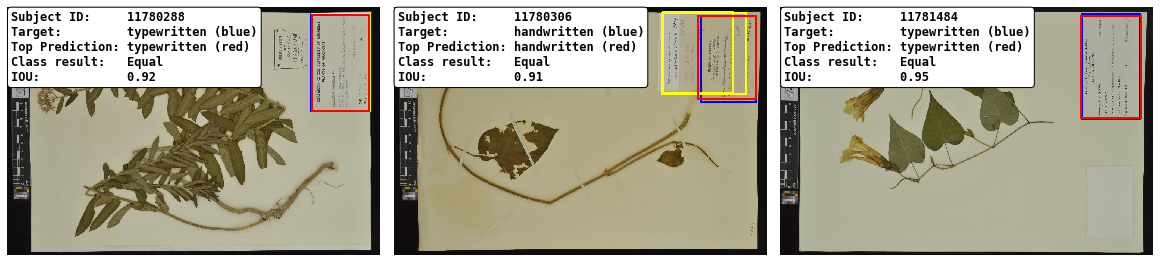

In [17]:
show_multiple_results([518, 520, 748], 4, 16)

# Object detection results IOU >= 80% and < 90%

Intersection over union 80-90%: 103 (8.47%)

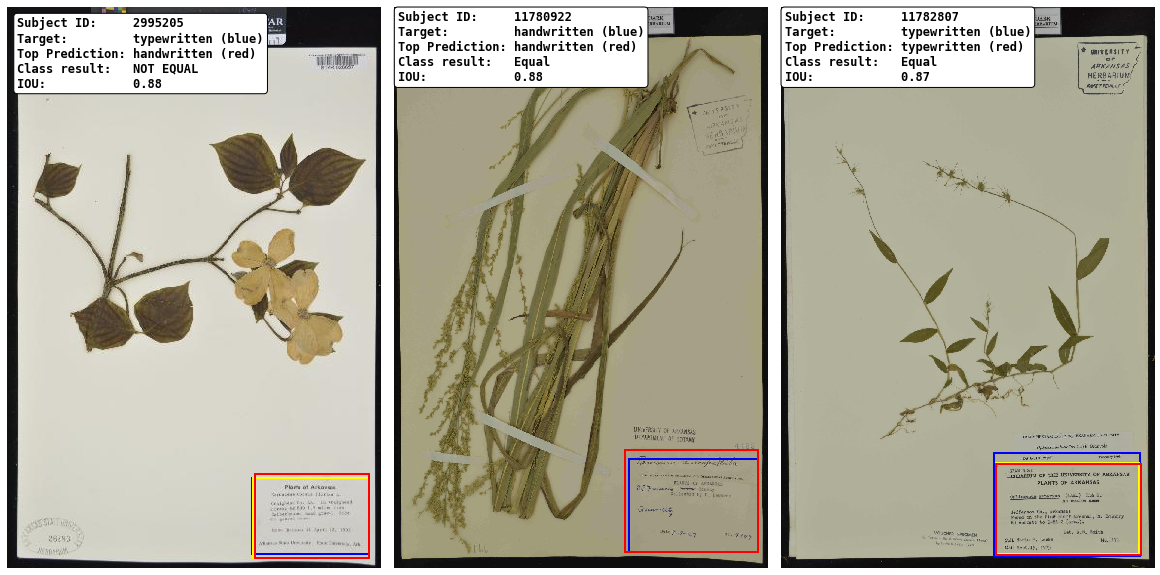

In [18]:
show_multiple_results([2, 637, 1029], 8)

# Object detection results IOU < 80%

Some of the times the model appears to do better than the volunteers, and other times not so much.

Intersection over union < 80%: 13 (1.07%)

| Index | Subject ID |
| ----- | ---------- |
| 7 | 2995235 |
| 67 | 2995585 |
| 136 | 4128416 |
| 145 | 4128467 |
| 171 | 4128609 |
| 306 | 10667753 |
| 410 | 10668286 |
| 509 | 11780234 |
| 1032 | 11782819 |
| 1077 | 11783073 |
| 1177 | 11783591 |
| 1182 | 11783605 |
| 1213 | 11783734 |

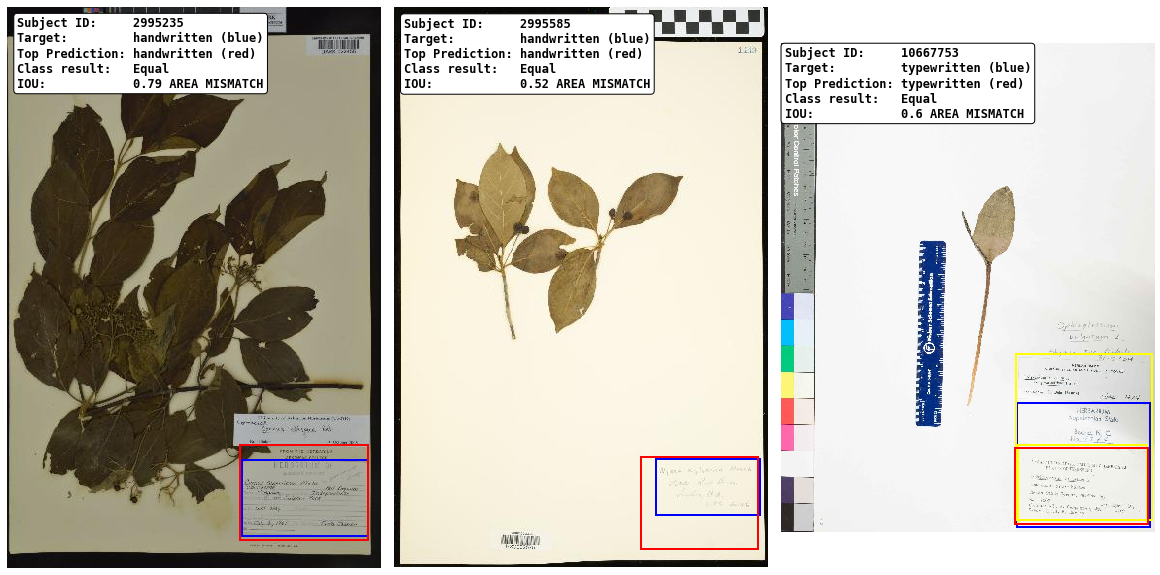

In [19]:
show_multiple_results([7, 67, 306], 8)

# Object detection results IOU = 0%

Notice that in each of these cases a ancillary choice does have a significant overlap with the target.

Intersection over union = 0%: 3 (0.25%)

| Index | Subject ID |
| ----- | ---------- |
| 496 | 11780193 |
| 763 | 11781551 |
| 1122 | 11783308 |

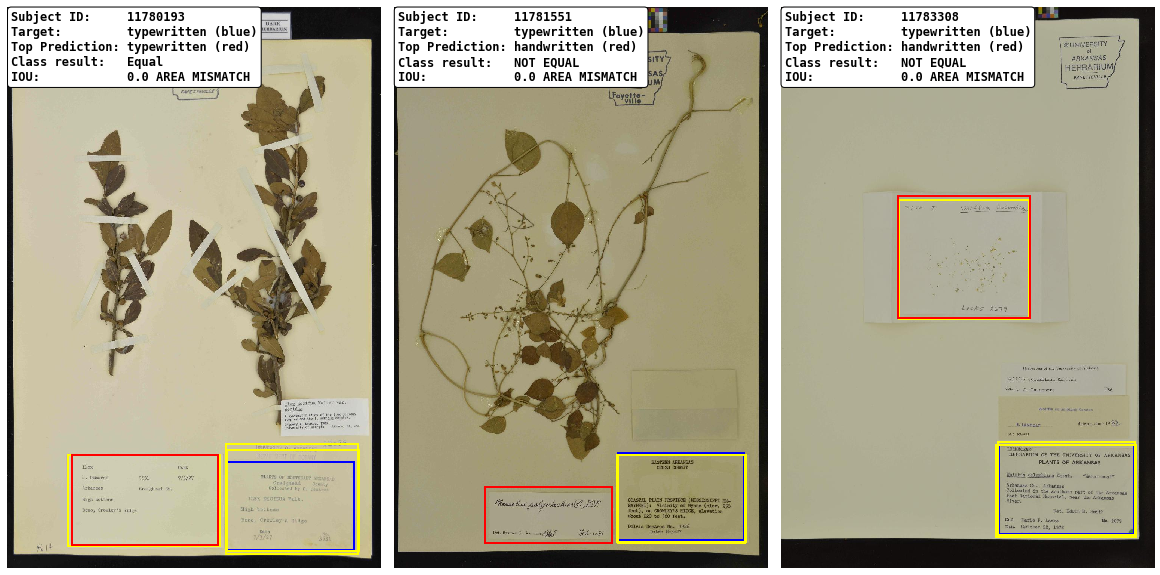

In [20]:
show_multiple_results([496, 763, 1122], 8)

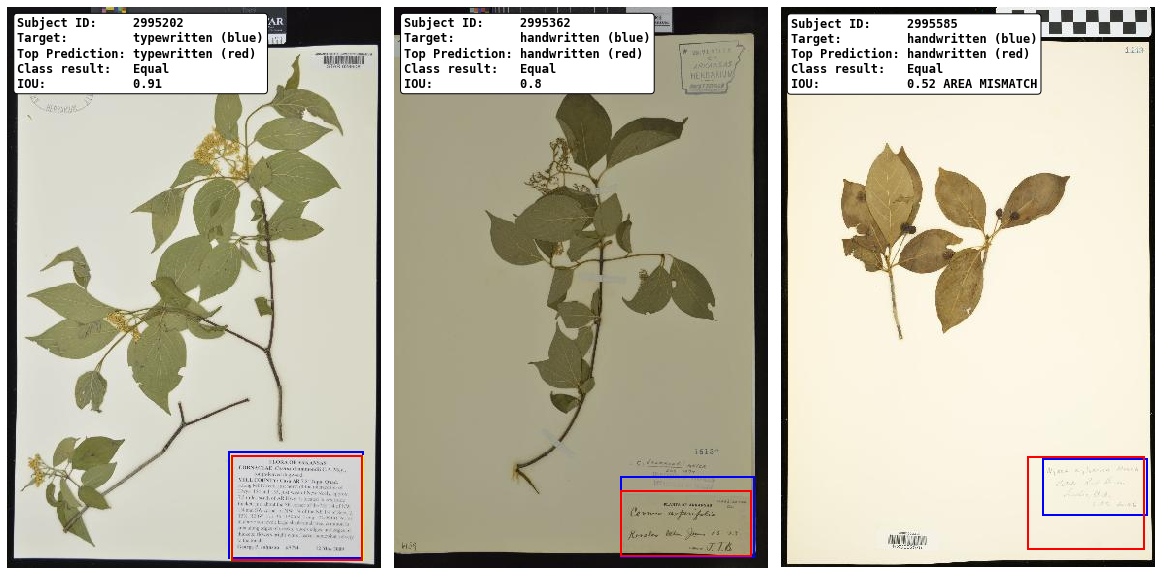

In [21]:
show_multiple_results([0, 23, 67], 8)

# Classification results

- There are 1216 items in the validation set.
- I included the "Both typewritten and handwritten" into the handwritten class.
- There were 1133 (93.17%) correctly identified classes.
- Handwritten misclassified as typewritten errors (4.93%).
- Typewritten misclassified as handwritten errors (1.89%).

# Handwritten misclassified as typewritten errors

Handwritten -> Typewritten errors (4.93%).

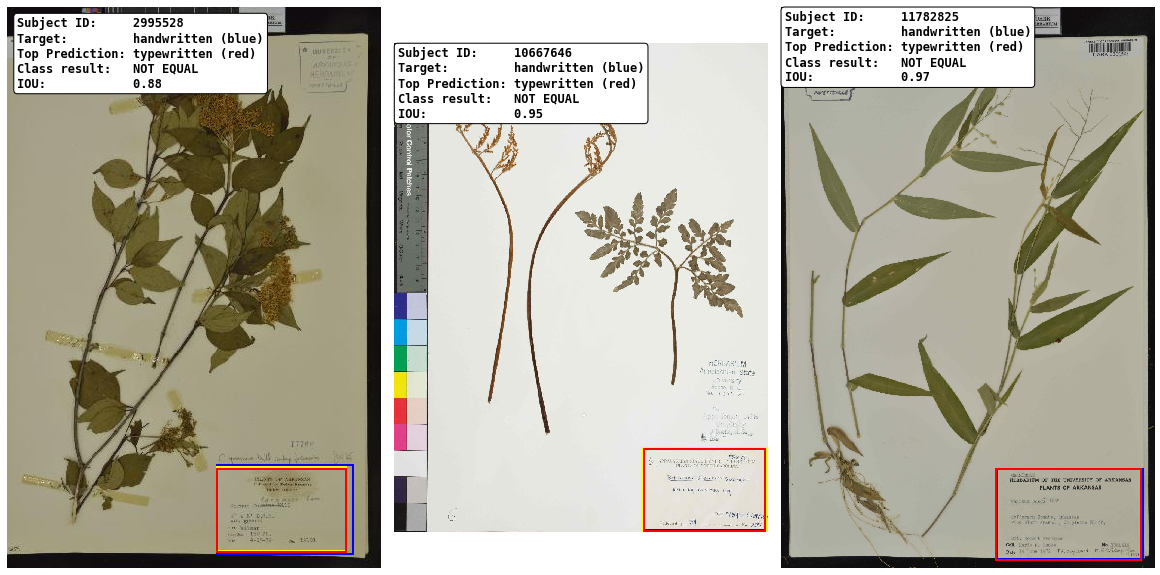

In [22]:
show_multiple_results([54, 281, 1033], 8)

# Typewritten misclassified as handwritten errors

Typewritten -> Handwritten errors (1.89%)

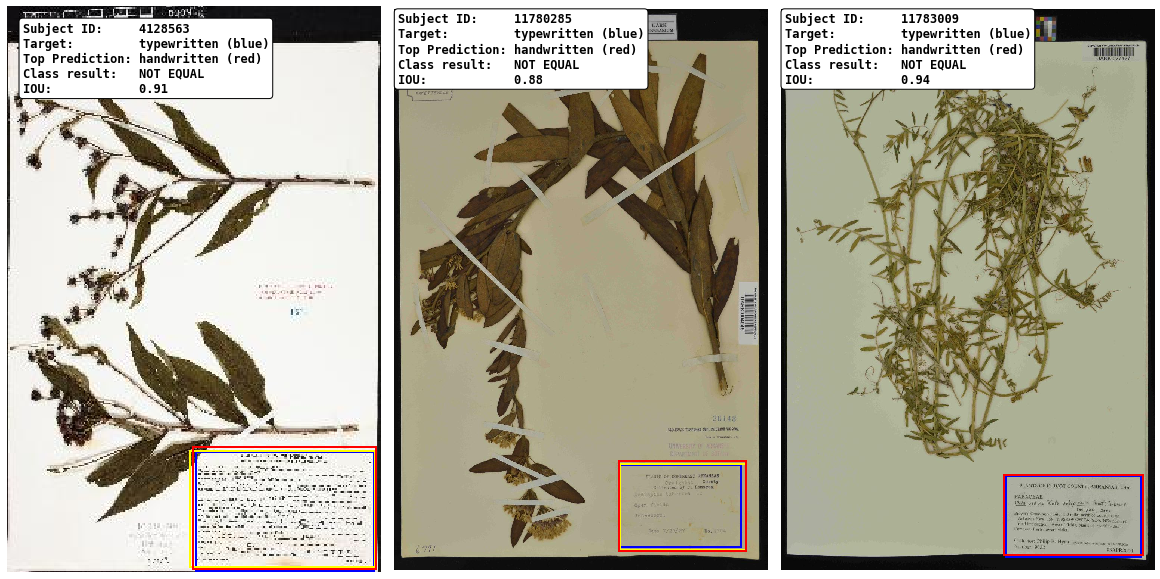

In [23]:
show_multiple_results([164, 517, 1064], 8)

# Get basic statistics on the results

In [24]:
def get_predictions(dataset, df):
    for idx, (image, target) in tqdm(enumerate(dataset)):
        t_class = target['labels'][0].numpy()
        t_box = target['boxes'][0].numpy()

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])

        p_class = 0
        p_box = [0, 0, 0, 0]
        if len(prediction[0]['labels'].cpu()):
            p_class = prediction[0]['labels'].cpu()[0].numpy()
            p_box = prediction[0]['boxes'].cpu()[0].numpy()

        df.at[idx, PRED_BOX] = p_box
        df.at[idx, PRED_CLASS] = p_class
        df.at[idx, IOU] = round(intersection_over_area(t_box, p_box), 2)

In [25]:
get_predictions(val_dataset, val_df)

series = pd.Series(CATS)
val_df[PRED_CAT] = val_df[PRED_CLASS].astype(int).map(series)

val_df.head()

1216it [02:10,  9.34it/s]


subject_id     category  class                   box  \
0     2995202  typewritten      2  [228, 459, 367, 568]   
1     2995203  typewritten      2  [238, 462, 377, 572]   
2     2995205  typewritten      2  [252, 486, 373, 564]   
3     2995213  typewritten      2  [224, 474, 373, 566]   
4     2995216  handwritten      1  [239, 462, 367, 562]   

                     path                 original predicted_class  \
0  data/valid/2995202.jpg  data/images/2995202.jpg               2   
1  data/valid/2995203.jpg  data/images/2995203.jpg               2   
2  data/valid/2995205.jpg  data/images/2995205.jpg               1   
3  data/valid/2995213.jpg  data/images/2995213.jpg               2   
4  data/valid/2995216.jpg  data/images/2995216.jpg               1   

  predicted_category                                 predicted_box  \
0        typewritten   [230.9913, 463.70532, 365.84637, 570.31104]   
1        typewritten   [235.3189, 464.53958, 376.01984, 573.87573]   
2        handwritten   [254.95781, 482.00076, 373.09686, 568.1067]   
3        typewritten   [224.12341, 477.11636, 371.32025, 565.2968]   
4        handwritten  [236.07832, 460.58536, 369.40036, 562.73517]   

                                      predicted_text   IoU  
0  FLORA OF ARK:\n\nCORNACEAE Cornus drummondii €...  0.91  
1  FLORA OF ARKANSAS.\nCULTIVATED!\nCORNACEAE\n\n...  0.94  
2                                                NaN  0.89  
3  CORNACEAE\nHERBARIUM OF THE UNIVERSITY OF ARKA...  0.95  
4                                                NaN  0.94

In [26]:
pd.crosstab(
    val_df[CAT],
    val_df[PRED_CAT],
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True)

Predicted    handwritten  typewritten   All
Actual                                     
handwritten          204           60   264
typewritten           23          929   952
All                  227          989  1216

In [27]:
bins = pd.cut(
    val_df[IOU],
    [0.0, 0.1, 0.8, 0.9, 1.0],
    right=False)

bins.value_counts()

[0.9, 1.0)    1097
[0.8, 0.9)     103
[0.1, 0.8)      13
[0.0, 0.1)       3
Name: IoU, dtype: int64

# To do

- Build a pipeline to extract the labels from the images
- Train the model for longer, possibly an order of magnitude more epochs.
- Augment the data: color jitter, image rotations, image flips, etc.
- Try smaller and faster models.
- Test the model on datasets from other herbaria.
- See if using the cropped labels in a new classifier yields better results.
- Try post-processing heuristics to improve the results.
- Code cleanup.

# Training stats just for kicks

In [25]:
get_predictions(trn_dataset, trn_df)

cats = pd.Series(CATS)
trn_df[PRED_CAT] = trn_df[PRED_CLASS].astype(int).map(cats)

4865it [08:22,  9.68it/s]


In [26]:
pd.crosstab(
    trn_df[CAT],
    trn_df[PRED_CAT],
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True)

Predicted    background  handwritten  typewritten   All
Actual                                                 
handwritten           1          823          185  1009
typewritten           0           38         3818  3856
All                   1          861         4003  4865

In [27]:
bins = pd.cut(
    trn_df[IOU],
    [0.0, 0.1, 0.8, 0.9, 1.0],
    right=False)

bins.value_counts()

[0.9, 1.0)    4501
[0.8, 0.9)     325
[0.1, 0.8)      33
[0.0, 0.1)       5
Name: IOU, dtype: int64

Look at the misses in the training dataset

In [28]:
trn_df.loc[trn_df[IOU] < 0.8 , :]

subject_id     category  class                      box  \
120     11781268  handwritten      1   [626, 1221, 966, 1408]   
123     11783325  handwritten      1   [606, 1112, 948, 1400]   
137     11782340  typewritten      2   [592, 1238, 943, 1430]   
1047    11782110  handwritten      1   [578, 1153, 964, 1463]   
1081    11781128  handwritten      1   [574, 1274, 980, 1477]   
1089    11780615  handwritten      1   [604, 1195, 945, 1450]   
1104    11782334  handwritten      1   [596, 1163, 984, 1466]   
1366    11783146  typewritten      2   [489, 1244, 972, 1480]   
1565    10667600  typewritten      2     [380, 673, 722, 895]   
1607    11783547  typewritten      2   [506, 1215, 966, 1464]   
1663    11783645  typewritten      2   [578, 1161, 974, 1462]   
1685    11781829  handwritten      1   [516, 1220, 994, 1446]   
1813     4128305  handwritten      1     [139, 300, 251, 382]   
1856    11780194  handwritten      1   [470, 1246, 964, 1460]   
1869    11783306  typewritten      2   [594, 1099, 958, 1426]   
2116     2995584  handwritten      1     [257, 504, 368, 569]   
2509    11783641  handwritten      1   [630, 1145, 985, 1410]   
2600     4128489  typewritten      2     [110, 312, 248, 385]   
2606    11782942  handwritten      1   [520, 1212, 985, 1455]   
2647     2995331  handwritten      1     [233, 456, 364, 561]   
2712    11783460  handwritten      1   [628, 1161, 971, 1480]   
2786     2995582  handwritten      1     [281, 515, 363, 565]   
2889     2995263  handwritten      1     [238, 432, 370, 562]   
2896     2995597  typewritten      2     [246, 494, 377, 566]   
3214    11783307  typewritten      2   [565, 1178, 945, 1417]   
3241    11782443  typewritten      2   [414, 1193, 956, 1449]   
3257     4128417  handwritten      1     [138, 328, 238, 384]   
3599    11782501  handwritten      1    [620, 985, 979, 1244]   
3770     4128892  typewritten      2     [194, 323, 287, 372]   
3901    11783715  typewritten      2   [599, 1162, 982, 1468]   
4091    11781216  typewritten      2   [492, 1215, 982, 1480]   
4150    10667655  handwritten      1  [579, 1092, 1000, 1310]   
4341    11782950  handwritten      1   [595, 1159, 975, 1382]   
4436    10667730  typewritten      2     [186, 625, 528, 859]   
4555    11782630  typewritten      2   [556, 1171, 940, 1473]   
4614    11780012  handwritten      1   [441, 1225, 976, 1482]   
4829    11780005  handwritten      1   [582, 1212, 974, 1480]   
4860    10667627  handwritten      1  [589, 1081, 1000, 1306]   

                         path                  original predicted_class  \
120   data/train/11781268.jpg  data/images/11781268.jpg               1   
123   data/train/11783325.jpg  data/images/11783325.jpg               1   
137   data/train/11782340.jpg  data/images/11782340.jpg               2   
1047  data/train/11782110.jpg  data/images/11782110.jpg               1   
1081  data/train/11781128.jpg  data/images/11781128.jpg               1   
1089  data/train/11780615.jpg  data/images/11780615.jpg               1   
1104  data/train/11782334.jpg  data/images/11782334.jpg               1   
1366  data/train/11783146.jpg  data/images/11783146.jpg               2   
1565  data/train/10667600.jpg  data/images/10667600.jpg               1   
1607  data/train/11783547.jpg  data/images/11783547.jpg               2   
1663  data/train/11783645.jpg  data/images/11783645.jpg               2   
1685  data/train/11781829.jpg  data/images/11781829.jpg               1   
1813   data/train/4128305.jpg   data/images/4128305.jpg               1   
1856  data/train/11780194.jpg  data/images/11780194.jpg               1   
1869  data/train/11783306.jpg  data/images/11783306.jpg               2   
2116   data/train/2995584.jpg   data/images/2995584.jpg               1   
2509  data/train/11783641.jpg  data/images/11783641.jpg               1   
2600   data/train/4128489.jpg   data/images/4128489.jpg               2   
2606  data/train/11782942.jpg  data/images/11

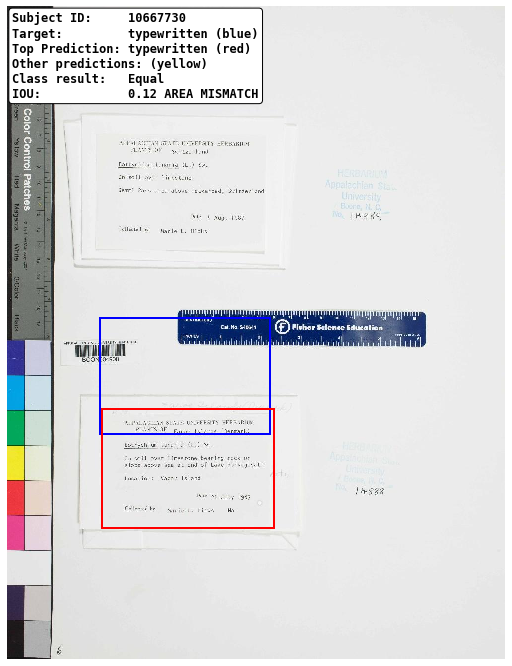

In [29]:
# interact(
#     show_results,
#     dataset=fixed(trn_dataset),
#     idx=(0, trn_df.shape[0] - 1),
#     figsize=([6, 8, 10, 12, 15, 20, 25]))
show_results(trn_dataset, 4436, 12)